# Annealing Algorithm Evaluation and OpenJij Benchmarking Capabilities

Since the annealing algorithm is a heuristic algorithm, it cannot always produce the optimal solution every single time.
Also, since it is a stochastic algorithm, solutions will differ each time. Therefore, when evaluating an algorithm, various kinds of averages are used to evaluate its solution. Commonly used metrics are:

- Time-to-solution (TTS)
- Success probability
- Residual energy

TTS is the computation time it takes to obtain an optimal solution with a certain probability, and this is often used in various evaluations.
Success probability is the probability that the optimal solution was obtained.
Residual energy is an average value that indicates how close the obtained solution was to the optimal solution.

In this note, we discuss the above three evaluation metrics and their measurement methods.

## Time-to-solution
Annealing algorithms can produce a solution with any computation time.
For example, in simulated annealing, the computation varies by how fast the temperature is varied.
However, it is meaningless if the solution is wrong even under fast computation.
Therefore, the computation time until the optimal solution is calculated with the required probability (e.g. the time to obtain the optimal solution with a 90% probability) is set as a metric.

As we covered in [Introduction to OpenJij](https://openjij.github.io/OpenJij/tutorial/en/000-intro_optimization_and_Ising.html), annealing algorithms search for the optimal solution among multiple runs, so it is necessary to take those multiple runs into account when evaluating the computation time.

> For example, even if a short computation time $\tau_{\mathrm{short}}$ returns a low probability of finding an optimal solution, annealing multiple times with that computation time $\tau_{short}$ may require less computation time and still perform as well as the one with a longer computation time $\tau_{\mathrm{long}}$.
> Therefore, when evaluating the computation time, simply comparing annealing times may not be sufficient.

TTS is the amount of time required for the above calculation, taking into account that annealing is performed multiple times.
It can be derived as follows.

Let $p_s(\tau)$ be the probability that the optimal solution is calculated in one annealing time $\tau$.
This $p_s(\tau)$ is the success probability, another metric to evaluate the algorithm.
The probability of the optimal solution not being calculated in one annealing is:

$$1-p_s(\tau)$$

Let us repeat this $R$ times.
Then, the probability that the optimal solution is not calculated in all these $R$ times is:

$$\{ 1-p_s(\tau)\}^R$$

Hence, $p_R$, the probability of obtaining an optimal solution at least once out of $R$ times can be obtained as follows:

$$p_R = 1-\{ 1-p_s(\tau)\}^R$$

Solving this equation for $R$ yields:

$$R = \frac{\ln(1-p_R)}{\ln\{1-p_s(\tau)\}}$$

Multiplying this by a single computation time $\tau$ leads to the total computation time.
Here we derived the TTS, the computation time required to obtain a solution.

$${\rm TTS}(\tau, p_R) = \tau R = \tau \frac{\ln(1-p_R)}{\ln\{1-p_s(\tau)\}}$$

${\rm TTS}(\tau, p_R)$ is the total computation time, which takes into account the number of iterations until an optimal solution is obtained with probability $p_R$ when one annealing takes $\tau$ computation time and an optimal solution is obtained with probability $p_s(\tau)$.

$p_R$ is given as a constant when evaluating actual problems.
$p_R=0.99$ is often used for research and other purposes.
$p_s(\tau)$ is calculated for various annealing times $\tau$, and then ${\rm TTS}(\tau, p_R)$ is derived.

In real problems, there are many cases where the optimal solution is not known.
In such cases, the **Time to Feasible Solution** is used.
This is calculated with the probability of obtaining a feasible solution instead of the probability of obtaining an optimal solution.

## Success Probability
The success probability simply calculates the probability of obtaining the optimal solution.
Assuming that the optimal solution is obtained $n$ times when annealing is repeated $R$ times, the success probability $p_s$ is:

$$p_s = \frac{n}{R}$$

## Residual Energy
Instead of time, as in TTS, an **approximation ratio** is another metric used for evaluation.
This is a metric that expresses how much cost was reduced compared to the optimal solution.
The approximate ratio is calculated as follows:

$$
r = \langle E \rangle / E_{\min}
$$

In physics, **residual energy**, the difference between the average energy and the optimal value, is also used for evaluation.

$$
E_{\text{res}} = \langle E \rangle - E_{\min}
$$
In many cases, the cost value of the problem is proportional to the number of variables $N$.
Therefore, we can normalize the energy by size as in $(\langle E \rangle - E_{\min})/N$.
Another method is to normalize by the optimal value $E_{\min}$, as in $(\langle E \rangle - E_{\min})/|E_{\min}|$.

Since the annealing algorithm is an algorithm with an asymptotic convergence to the optimal solution, in most cases the residual energy decreases as the annealing time increases.

### Experiments and Calculations of Evaluation Metrics with 1D Antiferromagnetic Ising Model

Let us calculate these evaluation metrics using OpenJij.  
In the following, we consider the 1D antiferromagnetic Ising model.
Antiferromagnetic is a magnetism that aligns with neighboring spins pointing in opposite directions.
This is a model represented by the following Hamiltonian:

$$H(\{\sigma_i\}) = \sum_{i=0}^{N-1} J_{i, i+1}\sigma_i \sigma_{i+1} + \sum_{i=0}^{N-1} h_i \sigma_i$$

Here we set $J_{i, i+1}=1$, $h_0 = -10$, and the other longitudinal magnetic fields to be 0.
From $J_{ij} > 0$ (antiferromagnetism), each spin is oriented differently to have lower energy.
Also from $h_0=-1$, we know that the 0th spin has $\sigma_0 =1$.
Therefore, the optimal solution $\{\sigma_i\}$ is $1, -1, 1, -1, -1, \cdots$, with the first one being 1 and the values alternating.

In other words, to find the TTS for this problem is to calculate the total computation time to obtain $1, -1, 1, \cdots$.
We solve the Ising model above and see how the TTS and the success probability change with increasing the time per calculation.

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

import openjij as oj 

In [3]:
# Create an 1D antiferromagnetic Ising model
N = 30
h = {0: -10}
J = {(i, i+1): 1 for i in range(N-1)}

## TTS Calculation

Response class returned from `sample_ising` or `sample_qubo` of OpenJij has a instance variable `info`.
It contains different information for each sampler in a dictionary type.
Most samplers have a key `'execution_time'` that stores the time (in $\mu s$) of one execution of each algorithm.
For SASampler, it stores the computation time per run of the simulated annealing algorithm.

In this section, we will use this computation time to calculate the TTS.

In [6]:
# Define the optimal solution.
correct_state = [(-1)**i for i in range(N)]
# Calculate the optimal value.
bqm = oj.BinaryQuadraticModel.from_ising(h, J)
minimum_energy = bqm.energy(correct_state)

# Define the pR to calculate TTS.
pR = 0.99

# Define num_sweeps_list.
# This will be passed to the sampler argument parameter.
# It is the number of divisions to decrease the parameters (temperature, transverse magnetic field) during annealing.
# Therefore, the more you increase it, the slower annealing corresponds to and the longer the annealing time will be.
num_sweeps_list = [30, 50, 80, 100, 150, 200, 300, 500]

TTS_list = []     # Define a list to store the TTS for each computation time.
tau_list = []     # Define a list to store computation times.
e_mean_list = []  # Define a list to store average energies.
e_min_list = []   # Define a list to store minimum energies.

ps_list = [] # Define a list to store success probability, which is obtained while calculating.


# Define the number of times to perform one annealing to calculate the probability.
num_reads = 1000

for num_sweeps in num_sweeps_list:
    sampler = oj.SASampler(num_sweeps=num_sweeps, num_reads=num_reads)  
    response = sampler.sample_ising(h, J)
    
    # Calculate ps. Count the number of energies below the optimal solution.
    energies = response.energies
    ps = len(energies[energies <= minimum_energy])/num_reads
    
    # Avoid TTS diverging to infinity when ps = 0.
    if ps == 0.0:
        continue
    
    ps_list.append(ps)
    # Calculate TTS.
    tau = response.info['execution_time']
    TTS_list.append(np.log(1-pR)/np.log(1-ps)*tau if ps < pR else tau)
    tau_list.append(tau)
    
    e_mean_list.append(np.mean(energies))
    e_min_list.append(np.min(energies))

Let us plot the TTS obtained and the dependence of the success probability over the annealing time.

Text(0, 0.5, 'Success probability')

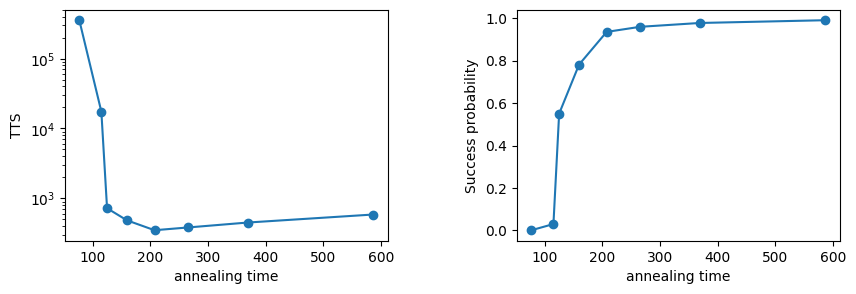

In [10]:
# Set plotting parameters.
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,3))
plt.subplots_adjust(wspace=0.4)
fontsize = 10

# Plot TTS.
axL.plot(tau_list, TTS_list, '-o')
axL.set_xlabel('annealing time', fontsize=fontsize)
axL.set_yscale("log")
axL.set_ylabel('TTS', fontsize=fontsize)

# Plot success probability ps.
axR.plot(tau_list, ps_list, '-o')
axR.set_xlabel('annealing time', fontsize=fontsize)
axR.set_ylabel('Success probability', fontsize=fontsize)

For both of the above two figures, the horizontal axis is the computation time per annealing.

In the success probability on the right figure, we see that it increases as the annealing time increases.
In this figure, the success probability roughly converges at an annealing time of around 200.

The TTS on the left shows that it decreases until the annealing time is about 200, i.e., the optimal solution is quickly obtained.
When annealing is slower than 200, TTS increases slowly.
This indicates a trend that the success probability relative to the annealing time is reaching its limit.

Therefore, we can use these as an indicator of when to stop annealing when the required success probability has been accomplished.
The smallest point in the TTS is the best computation time of the annealing algorithm for this instance.
This minimum TTS is a common metric of the algorithm's computation time.

The annealing algorithm is an algorithm for which there exists an asymptotic convergence to the optimal solution.
Therefore, in most cases, the residual energy decreases as the annealing time increases.
Plotting the dependence of the residual energy on annealing time confirms that the annealing algorithm is working well.
Knowing that the above OpenJij test saves the average value of energy, we plot the results.

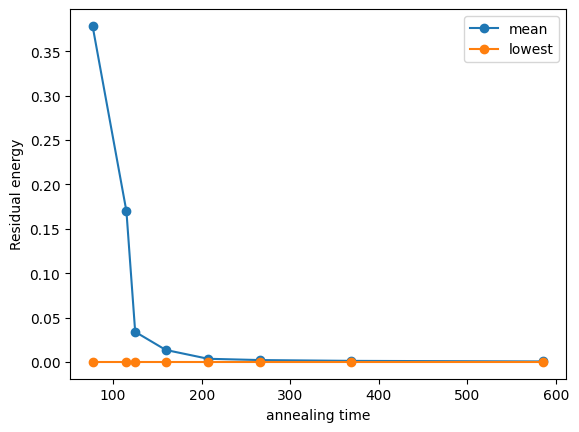

In [11]:
plt.plot(tau_list, (np.array(e_mean_list) - minimum_energy)/np.abs(minimum_energy), '-o', label='mean')
plt.plot(tau_list, (np.array(e_min_list) - minimum_energy)/np.abs(minimum_energy), '-o', label='lowest')
plt.xlabel('annealing time', fontsize=fontsize)
plt.ylabel('Residual energy', fontsize=fontsize)
plt.legend()
plt.show()

The average residual energy decreases as the annealing time increases.
Although we previously calculated TTS based on the success probability, residual energy is another useful indicator to check if annealing is going well, especially when the problem is too difficult to obtain the optimal solution.
This plot is useful to compare algorithms even when the optimal value is not known since the residual energy is a shift of the obtained energy value by the optimal value.

## Calculate Evaluation Metrics using OpenJij's Benchmarking Feature
Above, we manually scripted and calculated TTS, success probability, and residual energy to understand the principles.
However, OpenJij has a benchmark function `openjij.solver_benchmark` which evaluates TTS, success probability, and residual energy by default.  

### `solver_benchmark` Function

The `solver_benchmark` function calculates TTS, success probability, and residual energy and returns their values and standard errors.
The arguments and return values of the `solver_benchmark` function will be explained later.
First, we calculate using this benchmark function with the same settings as above.

In [12]:
# Define the optimal solution.
correct_state = [(-1)**i for i in range(N)]

# Define num_sweeps and num_reads (number of iterations)
num_sweeps_list = [30, 50, 80, 100, 150, 200,300,500]
num_reads = 1000

# Calculate TTS, success probability, and residual energy using benchmark function.
result = oj.solver_benchmark(
            solver=lambda time, **args: oj.SASampler(num_sweeps=time, num_reads=num_reads).sample_ising(h,J),
            time_list=num_sweeps_list, solutions=[correct_state], p_r=0.99
            )

Text(0, 0.5, 'Residual energy')

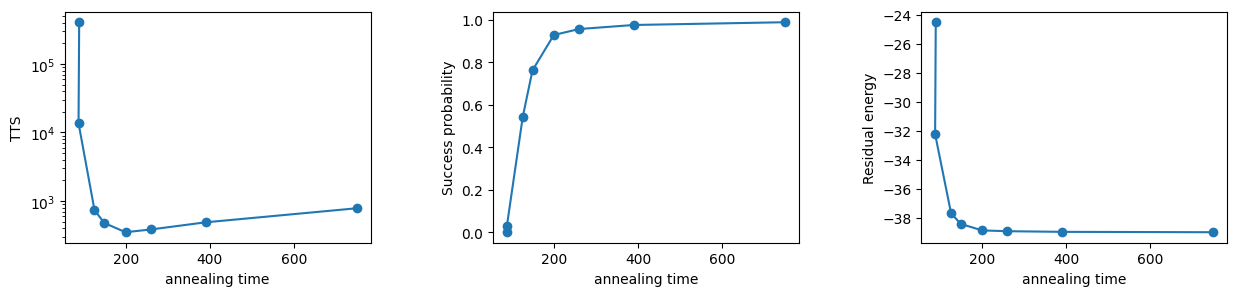

In [13]:
# Set plotting parameters.
fig, (axL,axC,axR) = plt.subplots(ncols=3, figsize=(15,3))
plt.subplots_adjust(wspace=0.4)
fontsize = 10

# Plot TTS
axL.plot(result['time'], result['tts'],'-o')
axL.set_xlabel('annealing time', fontsize=fontsize)
axL.set_yscale("log")
axL.set_ylabel('TTS', fontsize=fontsize)

# Plot success probability
axC.plot(result['time'], result['success_prob'],'-o')
axC.set_xlabel('annealing time', fontsize=fontsize)
axC.set_ylabel('Success probability', fontsize=fontsize)

# Plot residual energy
axR.plot(result['time'], result['residual_energy'],'-o')
axR.set_xlabel('annealing time', fontsize=fontsize)
axR.set_ylabel('Residual energy', fontsize=fontsize)

The same results are reproduced as earlier as we easily benchmarked with this function.

Furthermore, the `solver_benchmark` function also calculates the standard error, and plotting the results with error bars can be done easily.

Text(0, 0.5, 'Residual energy')

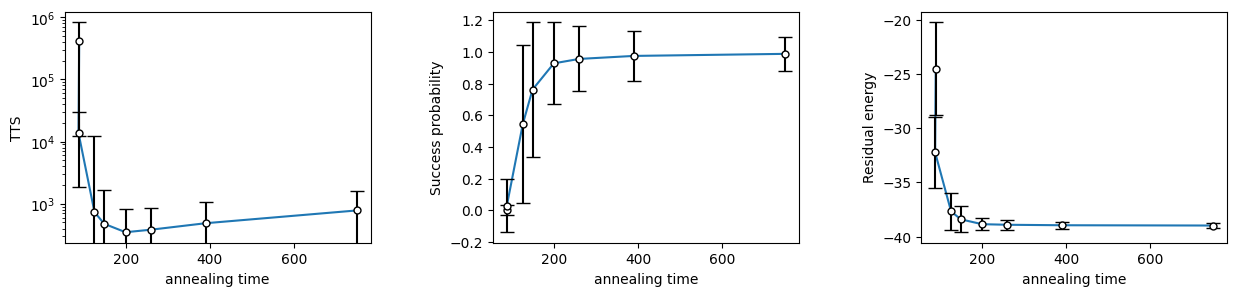

In [15]:
# Set plotting parameters.
fig, (axL,axC,axR) = plt.subplots(ncols=3, figsize=(15,3))
plt.subplots_adjust(wspace=0.4)
fontsize = 10

# Plot TTS with error bars.
axL.plot(result['time'], result['tts'])
axL.errorbar(result['time'], result['tts'], yerr = (result['se_lower_tts'],result['se_upper_tts']), capsize=5, fmt='o', markersize=5, ecolor='black', markeredgecolor = "black", color='w')
axL.set_xlabel('annealing time', fontsize=fontsize)
axL.set_ylabel('TTS', fontsize=fontsize)
axL.set_yscale("log")

#Plot success probability with error bars.
axC.plot(result['time'], result['success_prob'])
axC.errorbar(result['time'], result['success_prob'], yerr = result['se_success_prob'], capsize=5, fmt='o', markersize=5, ecolor='black', markeredgecolor = "black", color='w')
axC.set_xlabel('annealing time', fontsize=fontsize)
axC.set_ylabel('Success probability', fontsize=fontsize)

#Plot residual energy with error bars
axR.plot(result['time'], result['residual_energy'])
axR.errorbar(result['time'], result['residual_energy'], yerr = result['se_residual_energy'], capsize=5, fmt='o', markersize=5, ecolor='black', markeredgecolor = "black", color='w')
axR.set_xlabel('annealing time', fontsize=fontsize)
axR.set_ylabel('Residual energy', fontsize=fontsize)

## Benchmarking with User-defined Functions

Any user-defined function can be put in `solver` as long as it returns a `Response` class and stores the calculation time in `.info['execution_time']`.  

Here we create an appropriate user-defined solver function and benchmark it.
Let us define a function that returns one state at random from the three spin states of [1, 1, 1, 1, ...], [1, -1, 1, -1, ...], and [-1, 1, -1, 1, ...] and benchmark it. We set the optimal solution to [1, -1, 1, -1,...].

In [16]:
import time 

def anti_ferro_solver(time_param, num_reads, h, J):
#     """
#     This function randomly selects from three states [1, 1, 1,...], [1,-1,1,...], and [-1,1,-1,...]
#     """
    
    # Create a set of indices from h and J.
    indices = set(h.keys())
    indices = list(indices | set([key for keys in J.keys() for key in keys]))
    
    # Create the state of [1, 1, 1,...]
    ones_state = list(np.ones(len(indices), dtype=int))
    
    # Create the state of [-1, 1, -1,...]
    minus_plus_state = np.ones(len(indices), dtype=int)
    minus_plus_state[::2] *= -1
    
    # Create the state of [1, -1, 1,...]
    plus_minus_state = -1 * minus_plus_state
    
    # Measure the execution time.
    start = time.time()
    _states = [ones_state, list(minus_plus_state), list(plus_minus_state)]
    
    # Randomly select one state from the three states.
    state_record = [_states[np.random.randint(3)] for _ in range(num_reads)]
    # Convert the state_record type to ndarray.
    state_record = np.array(state_record)
    
    # Here we bulk up the computation time suitably.
    exec_time = (time.time()-start) * 10**3 * time_param
    # Here we calculate energies suitably.
    energies = [sum(state) for state in state_record]
    
    # Tie the subscripts to the list of states.
    samples_like = (state_record, indices)
        
    # Referring to dimod's from_samples, store the state and energy in the response class.
    response = oj.Response.from_samples(samples_like=samples_like, energy=energies, vartype='SPIN')
    # Substitute the computation time to the 'execution_time' key in response.info.
    response.info['execution_time'] = exec_time
    
    return response

OpenJij's response is made with reference to dimod's SampleSet.
Therefore, being familiar with OpenJij will help use dimod and transit to D-Wave execution.
For more information on dimod's SampleSet, please see [dimod's samples page](https://docs.ocean.dwavesys.com/en/stable/docs_dimod/reference/sampleset.html#).

Having our own solver function, let us take the benchmark of this function.
Since we are returning random states, there is no optimal value, but for the sake of TTS calculation, let `[1, -1, 1,...]` be the optimal solution.

In [24]:
# Define the optimal solution.
correct_state = [(-1)**i for i in range(N)]

# Define num_sweeps and num_reads
num_sweeps_list = list(range(10, 101, 10))
num_reads = 2000

# Calculate TTS, success probability, and residual energy using benchmark function.
result = oj.solver_benchmark(
            solver= lambda time_param, **args: anti_ferro_solver(time_param, num_reads, h, J), 
            time_list=num_sweeps_list, solutions=[correct_state], p_r=0.99
            )

Text(0, 0.5, 'Residual energy')

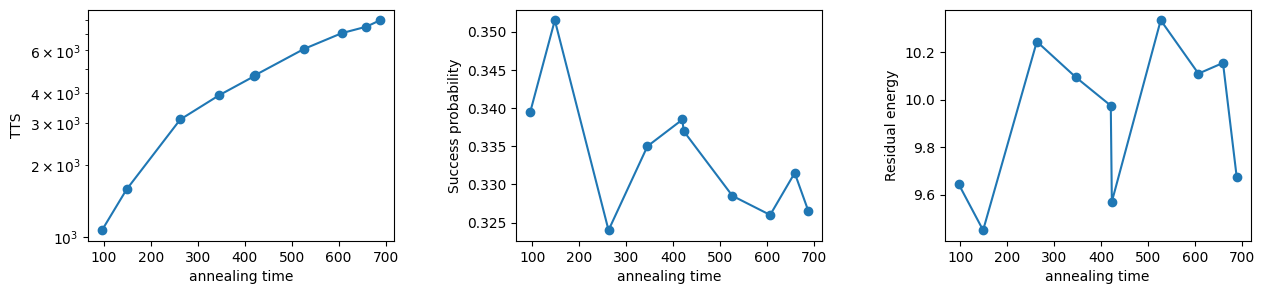

In [25]:
# Set plotting parameters.
fig, (axL,axC,axR) = plt.subplots(ncols=3, figsize=(15,3))
plt.subplots_adjust(wspace=0.4)
fontsize = 10

# Plot TTS
axL.plot(result['time'], result['tts'],'-o')
axL.set_xlabel('annealing time', fontsize=fontsize)
axL.set_yscale("log")
axL.set_ylabel('TTS', fontsize=fontsize)

# Plot success probability
axC.plot(result['time'], result['success_prob'],'-o')
axC.set_xlabel('annealing time', fontsize=fontsize)
axC.set_ylabel('Success probability', fontsize=fontsize)

# Plot residual energy
axR.plot(result['time'], result['residual_energy'],'-o')
axR.set_xlabel('annealing time', fontsize=fontsize)
axR.set_ylabel('Residual energy', fontsize=fontsize)

Since the optimal solution is randomly selected from the three states, the success probability should be about $1/3\approx 0.33\cdots$.  
Note that the value of the success probability above is around that value.

If you create a solver function, you can calculate TTS, success probability, and residual energy for not only OpenJij's solver but also for your own solver. 

### Details of the `solver_benchmark` Function
We finally describe the arguments and the return values of the `solver_benchmark` function.

#### Arguments of the `solver_benchmark` Function

- solver: function  
    A function that returns the `Response` class. It must have the arguments `time` and `num_reads`.
    The `time` is a parameter that controls the computation time. In the case of `SASampler`, it corresponds to `num_sweeps`.
    The `num_reads` parameter specifies the number of sampling times required to calculate TTS, residual energy, etc. The `num_reads` parameter is the number of reads required to calculate TTS, residual energy, etc.
    Also, `Response.info`, the return value of the function, must have a keyword string specified by the argument `time_name`, and the value associated with `time_name` must contain the calculation time per calculation.
- time_list: list  
    A list of values to put into the `time` argument of the solver.
- solutions: list(list: state)  
    A list of states that will be the optimal solution. In case of degeneracy (multiple identical states), multiple states should be entered, e.g. [state1, state2].
- args: dict
    This is an optional parameter for the solver. The default value is `args = {}`.
- p_r: 0 < float <= 1  
    This is the value needed to calculate TTS. Equivalent to $p_R$ in the TTS description above.
- ref_energy: float  
    Reference energy. Used in conjunction with the following `measure_with_energy`. The default value is `ref_energy = 0`.
- measure_with_energy: bool  
    False: counts as a success if the spin state matches the optimal state.  
    True: counts as a success if the energy is less than or equal to the `ref_energy`. This is used when the optimal state is not known.  
    The default value is False.
- time_name: str  
    Specifies the key associated with the execution time in `Response.info`. The default value is `'execution_time'`.

#### Return Value of the `solver_benchmark` Function
The return value is the result of the benchmark calculation, stored in a dictionary type as follows.

- time: List of execution times
- success_prob: List of success probabilities
- tts: List of TTS
- residual_energy: List of residual energies
- info: (dict) Parameter information of the benchmark function
- se_success_prob: List of standard errors of success probability  
      The standard deviation of the expected value of success probability for each iteration of annealing
      Stored for each step_num
      
- se_residual_energy: List of standard errors of residual energy  
      The standard deviation of the mean of the residual energy for each iteration of annealing
      Stored for each step_num

- se_lower_tts: List of lower standard errors of TTS

- se_upper_tts: List of upper standard errors of TTS